In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/vlawhern/arl-eegmodels.git

Cloning into 'arl-eegmodels'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 112 (delta 1), reused 4 (delta 1), pack-reused 106
Receiving objects: 100% (112/112), 80.61 KiB | 620.00 KiB/s, done.
Resolving deltas: 100% (48/48), done.


In [3]:
!pip install mne
!pip install PyRiemann
!pip install mat73

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyRiemann: filename=pyriemann-0.5-py2.py3-none-any.whl size=107752 sha256=6c4db46c7840d8495d44b85a8fddf53e1e07d0f2625836a7ba8c1b886e85f0d5
  Stored in directory: /root/.cache/pip/wheels/84/86/79/622e9c1dc933dc088e287ebfaac5aa9bdc6a38a9db193ce1f1
Successfully built PyRiemann


In [2]:
from tqdm import tqdm
import mat73
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC




#
# vpae_dict = mat73.loadmat("VPae.mat")
# raw_eeg, epoch = load_MATLAB_data(participant_data=vpae_dict)

In [3]:
cd arl-eegmodels

c:\Users\G7\Desktop\EEG_Analysis\arl-eegmodels


In [4]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet


ModuleNotFoundError: No module named 'tensorflow'

In [7]:
model  = EEGNet(nb_classes = 1, Chans = 59, Samples = 301)

In [8]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam')


In [9]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 59, 301, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 59, 301, 8)        512       
                                                                 
 batch_normalization (Batch  (None, 59, 301, 8)        32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 301, 16)        944       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 1, 301, 16)        64        
 chNormalization)                                                
                                                             

In [ ]:
from pandas import DataFrame
import pandas as pd
import mat73

In [ ]:
#processing MATLAB Function

import mat73
import numpy as np
import mne


chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']



def load_MATLAB_data(dir=None, participant_data=None):
    if dir==None and participant_data==None: raise Exception("Must provide directory or dicitionary")
    # print(dir)
    #load data
    if participant_data == None:
      participant_data = mat73.loadmat(dir)

    eeg_names = chan_names[1:61]
    eeg_names.pop(4)


    #create MNE info object
    sfreq = 200
    n_channels = 59
    # Initialize an info structure
    info = mne.create_info(
            ch_names = eeg_names,
            ch_types = ['eeg']*n_channels,
            sfreq    = sfreq
            )

    info.set_montage('standard_1020')

    #create labels
    Y  = participant_data['mrk']['y']
    Y = np.rollaxis(Y, 1, 0)
    loc, ind = np.where(Y>0)
    np.unique(ind)
    labels = ind + 1

    #create event dict
    event_id = dict(car_normal = 1, car_brake = 2,	car_hold = 3,	car_collision = 4,	react_emg = 5)
    eventLength = Y.shape[0]
    ev = np.array([int(participant_data['mrk']['time'][i]/5) for i in range(eventLength)])
    #delete duplicates
    # ev = np.delete(ev, 578, 0)
    # labels = np.delete(labels, 578, 0)

    events = np.column_stack((np.array(ev),
                          np.zeros(eventLength,  dtype = int),
                          np.array(labels)))

    #get time intervals around each y
    stim_slices = [participant_data['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in participant_data['mrk']['time']]


    # stim_slices.pop(578) #remove duplicates

    #reshape data
    npdata = np.array(stim_slices, dtype=object,)
    npdata = np.swapaxes(npdata, 1,2)
    npdata = np.delete(npdata, 0, 1)
    npdata = np.delete(npdata, 4, 1)
    npdata = np.delete(npdata, np.s_[59:], 1)

    # tmin = 0
    #     # Create the :class:`mne.EpochsArray` object
    # epochs = mne.EpochsArray(npdata, info, events, tmin, event_id)

    raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

    raw_data = np.delete(raw_data, 0, 0)
    raw_data = np.delete(raw_data, 4, 0)
    raw_data = np.delete(raw_data, np.s_[59:], 0)

    raw_eeg = mne.io.RawArray(raw_data,info, verbose=True)


    epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)



    return raw_eeg, epochs


In [ ]:
def export_data_csv(dir, len):
    vpae_dict = mat73.loadmat(dir)
    raw_eeg, epoch = load_MATLAB_data(participant_data=vpae_dict)


    non_targets = []
    data_pairs = list(zip(vpae_dict['mrk']['time'], vpae_dict['mrk']['time'][1:]))
    data_pairs = [(int(a[0]/5), int(a[1]/5)) for a in data_pairs]
    # npTarget = np.delete(npTarget, npFiltered, 1)
    for pr in data_pairs:
        counter = pr[0] + 600
        while (counter < pr[1]-900):
            non_targets.append(vpae_dict['cnt']['x'][counter:counter+301])
            counter += 301

    # data_pairs = [(vpae_dict['mrk']['time'][i], vpae_dict['mrk']['time'][i+1]) for i in range(len(vpae_dict['mrk']['time'])-1)]
    # for vpae_dict in mat_dicts:
    npFiltered = np.where(np.std(epoch['car_normal'].average().get_data(), axis=1) > 2)
    print(npFiltered)

    npNonTarget = np.array(non_targets)
    npNonTarget = np.swapaxes(npNonTarget, 1,2)
    npNonTarget = np.delete(npNonTarget, 0, 1)
    npNonTarget = np.delete(npNonTarget, 4, 1)
    npNonTarget = np.delete(npNonTarget, np.s_[59:], 1)
    # npNonTarget = np.delete(npNonTarget, npFiltered, 1)

    # npNonTarget = mne.baseline.rescale(npNonTarget, )

    # st = 40

    indices = list(np.where(vpae_dict['mrk']['y'][1] == 1.0)[0])
    times = [vpae_dict['mrk']['time'][x] for x in indices]



    # targets = []
    # for i in range(vpae_dict['mrk']['time'].shape[0]):
    #     if (vpae_dict['mrk']['y'][1][i]):
    #         t = int(vpae_dict['mrk']['time'][i]/5)
    #         targets.append(vpae_dict['cnt']['x'][t+len-300:t+len+1])

    # stim_slices = [vpae_dict['cnt']['x'][int(idx/5)-60:int(idx/5)+240] for idx in vpae_dict['mrk']['time']]
    targets = np.array([vpae_dict['cnt']['x'][int(idx/5)+len-1:int(idx/5)+len+300] for idx in times])
    # targets = [vpae_dict['cnt']['x'][int(idx/5)+len:int(idx/5)+len+1] for idx in times]


    npTarget = np.array(targets)
    npTarget = np.swapaxes(npTarget, 1,2)
    npTarget = np.delete(npTarget, 0, 1)
    npTarget = np.delete(npTarget, 4, 1)
    npTarget = np.delete(npTarget, np.s_[59:], 1)
    # npTarget = np.delete(npTarget,npFiltered, 1)


    TR = npTarget #.copy()
    TR = np.swapaxes(TR, 1, 2)
    # TR = TR[0:,0:len+1,0:]
    TR = np.swapaxes(TR, 0, 1)
    # print(TR.shape)
    TR = np.mean(TR, axis=2)
    TR = np.swapaxes(TR, 0, 1)

    FL = npNonTarget #.copy()
    # FL = epochs['car_normal'].get_data()
    FL = np.swapaxes(FL, 1, 2)
    # FL = FL[0:,0:len+1,0:]
    FL = np.swapaxes(FL, 0, 1)
    FL = np.mean(FL, axis=2)
    FL = np.swapaxes(FL, 0, 1)

    TrueLabels = [1 for sample in range(TR.shape[0])]
    FalseLabels = [0 for sample in range(FL.shape[0])]

    X = np.concatenate((TR, FL))
    y = np.concatenate((TrueLabels, FalseLabels))
    y = np.expand_dims(y, axis=1)

    return np.concatenate((npNonTarget, npTarget)), y




In [ ]:
X, y = export_data_csv("/content/drive/Shareddrives/EEG_Data/EEG_Analysis/VPae.mat", 340)

Creating RawArray with float64 data, n_channels=59, n_times=1619936
    Range : 0 ... 1619935 =      0.000 ...  8099.675 secs
Ready.
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
913 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 913 events and 301 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
(array([ 0,  1,  2,  3,  4,  5, 11, 12, 13, 20, 21, 22, 30, 33, 40, 50, 57,
       58]),)


In [ ]:
X.shape

(4064, 59, 301)

In [ ]:
y.shape

(4064, 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# oversampling and undersampling
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
kfold.get_n_splits(X,y_train)

2

In [ ]:
#  X_train_over,y_train_over= oversample.fit_resample(X_train, y_train)

ValueError: ignored

## Different Data

In [10]:
import mat73
import numpy as np
import mne


participant_data = mat73.loadmat("/content/drive/Shareddrives/EEG_Data/EEG_Analysis/VPdx.mat")

labels = []
non_targets = []
data_pairs = list(zip(participant_data['mrk']['time'], participant_data['mrk']['time'][1:]))
data_pairs = [(int(a[0]/5), int(a[1]/5)) for a in data_pairs]
# npTarget = np.delete(npTarget, npFiltered, 1)
for pr in data_pairs:
    counter = pr[0] + 600
    while (counter < pr[1]-900):
        # non_targets.append(vpae_dict['cnt']['x'][counter:counter+301])
        non_targets.append(counter)
        labels.append(1)
        counter += 301

ev = []
for i in range(participant_data['mrk']['y'].shape[1]):
    if participant_data['mrk']['y'][1][i]:
        ev.append(int(participant_data['mrk']['time'][i]/5))
        labels.append(2)
ev = np.array(ev)
labels = np.array(labels)


non_targets = np.array(non_targets)

evs = np.concatenate((non_targets, ev))

events = np.column_stack((np.array(evs),
                        np.zeros(evs.shape[0],  dtype = int),
                        np.array(labels)))

In [11]:
print(events.shape)
# print(Y[:,1].shape)
# print(Y[:,1][Y[:,1] == 1].shape)

chan_names = ['EOGv', 'Fp1', 'Fp2', 'AF3', 'AF4', 'EOGh', 'F7', 'F5', 'F3', 'F1' , 'Fz' , 'F2' , 'F4' , 'F6' , 'F8' , 'FT7' , 'FC5' , 'FC3' ,
              'FC1' , 'FCz' , 'FC2' , 'FC4' , 'FC6' , 'FT8' , 'T7' , 'C5' , 'C3' , 'C1' , 'Cz' , 'C2' , 'C4' , 'C6' , 'T8' , 'TP7' , 'CP5' ,
              'CP3' , 'CP1' , 'CPz' , 'CP2' , 'CP4' , 'CP6' , 'TP8' , 'P9' , 'P7' , 'P5' , 'P3' , 'P1' , 'Pz' , 'P2' , 'P4' , 'P6' , 'P8' ,
            'P10' , 'PO7' , 'PO3' , 'POz' , 'PO4' , 'PO8' , 'O1' , 'Oz' , 'O2' , 'EMGf' , 'lead_gas','lead_brake','dist_to_lead',
              'wheel_X','wheel_Y','gas','brake']

eeg_names = chan_names[1:61]
eeg_names.pop(4)
#create MNE info object
sfreq = 200
n_channels = 59
# Initialize an info structure
info = mne.create_info(
        ch_names = eeg_names,
        ch_types = ['eeg']*n_channels,
        sfreq    = sfreq
        )

info.set_montage('standard_1020')
event_id = dict(car_normal = 1, car_brake = 2)

raw_data = np.swapaxes(np.array(participant_data['cnt']['x']), 0, 1)

raw_data = np.delete(raw_data, 0, 0)
raw_data = np.delete(raw_data, 4, 0)
raw_data = np.delete(raw_data, np.s_[59:], 0)

raw_eeg = mne.io.RawArray(raw_data,info, verbose=True)


# epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-1.7, tmax=1.2, preload=True, event_repeated='drop', verbose=True)
epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)

(4119, 3)
Creating RawArray with float64 data, n_channels=59, n_times=1619949
    Range : 0 ... 1619948 =      0.000 ...  8099.740 secs
Ready.
Not setting metadata
4119 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 4119 events and 301 original time points ...


<ipython-input-11-73f4cef899a5>:36: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw_eeg, events, event_id=event_id, tmin=-0.3, tmax=1.2, preload=True, event_repeated='drop', verbose=True)


0 bad epochs dropped


In [15]:
TR = epochs["car_brake"].get_data() #.copy()

# TR = np.swapaxes(TR, 1, 2)
# TR = TR[0:,0:len+1,0:]
TR = np.swapaxes(TR, 0, 1)
# print(TR.shape)
TR = np.swapaxes(TR, 0, 1)

FL = epochs["car_normal"].get_data() #.copy()
# FL = np.swapaxes(FL, 1, 2)
# FL = FL[0:,0:len+1,0:]
FL = np.swapaxes(FL, 0, 1)
FL = np.swapaxes(FL, 0, 1)

TrueLabels = [1 for sample in range(TR.shape[0])]
FalseLabels = [0 for sample in range(FL.shape[0])]

X = np.concatenate((TR, FL))
X = np.expand_dims(X, axis=3)
y = np.concatenate((TrueLabels, FalseLabels))
y = np.expand_dims(y, axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test[y_test == 1].shape)


(2059, 59, 301, 1)
(2059, 1)
(2060, 59, 301, 1)
(108,)


In [17]:
fittedModel = model.fit(X_train,y_train, epochs=10)


Epoch 1/10
65/65 [==============================] - 59s 865ms/step - loss: 0.5775
Epoch 2/10
65/65 [==============================] - 50s 773ms/step - loss: 0.4283
Epoch 3/10
65/65 [==============================] - 50s 766ms/step - loss: 0.3610
Epoch 4/10
65/65 [==============================] - 50s 773ms/step - loss: 0.3015
Epoch 5/10
65/65 [==============================] - 48s 734ms/step - loss: 0.2689
Epoch 6/10
65/65 [==============================] - 48s 740ms/step - loss: 0.2490
Epoch 7/10
65/65 [==============================] - 51s 789ms/step - loss: 0.2293
Epoch 8/10
65/65 [==============================] - 52s 793ms/step - loss: 0.2146
Epoch 9/10
65/65 [==============================] - 48s 733ms/step - loss: 0.2044
Epoch 10/10
65/65 [==============================] - 52s 810ms/step - loss: 0.1946


In [18]:
model_pred = []

In [19]:
from sklearn import metrics

pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
model_pred.append(score)
print("Validation score: {}".format(score))

65/65 [==============================] - 8s 118ms/step
Validation score: 1.0


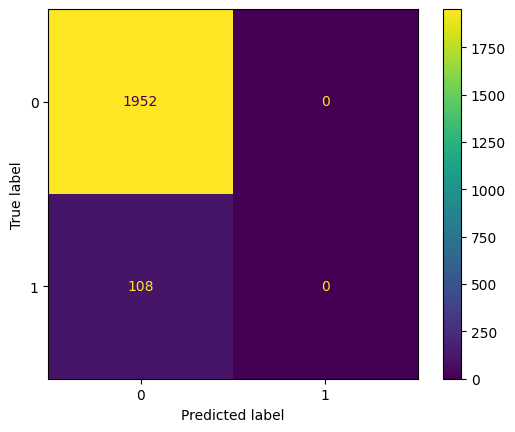

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, pred)



In [21]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score

acc = accuracy_score(y_test, pred)
# y_pred_proba = model.predict_proba(X_test)[:, 1]
# auc_score = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, pred)

print('EEGNet Accuracy :', acc)
# print('EEGNet AUC Score :', auc_score)
print('EEGNet F1 Score :', f1)


EEGNet Accuracy : 0.9475728155339805
EEGNet F1 Score : 0.0


In [22]:
from sklearn.metrics import classification_report

target_names = ['car_normal','car_collision']
report = classification_report(labels, pred, target_names=target_names)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(labels, pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1, layout="constrained")
im = ax.imshow(cm_normalized, interpolation="nearest", cmap=plt.cm.Blues)
ax.set(title="Normalized Confusion matrix")
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
ax.set(ylabel="True label", xlabel="Predicted label")

ValueError: ignored

In [ ]:
import time
import random

start = time.time()
randomIndex = random.randint(0, len(X_test) - 1)

sampleInput = X_test[randomIndex]
sampleInput = sampleInput[None,:,:,:]

print(sampleInput.shape)
model.predict(sampleInput)
end = time.time()
print('Time taken: ', end-start)